<a href="https://colab.research.google.com/github/juliosdutra/Controle_de_Processos_UFES/blob/main/8.Class-Projects/2023_02_Trabalho_Controle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **APRESENTAÇÃO**

## Integrantes

*   Júlia Almeida de Abreu Moraes (2019109609) - julia.a.moraes@edu.ufes.br
*   Laisa Cristina Juffo Campos (2019107489) - laisa.c.campos@edu.ufes.br
*   Marcelo Lopes Cocco (2019107490) - marcelo.cocco@edu.ufes.br

## Sobre

Atividade prática apresentada para a disciplina de Controle de Processos, no semestre letivo 2023/02.


# **INTRODUÇÃO**

O rápido avanço tecnológico das últimas décadas proporcionou inegáveis melhorias em diversas áreas, como o controle e monitoramento de processos. Na engenharia química, as atividades que envolvem a manutenção e operação de plantas estão relacionadas a processos complexos, que envolvem balanços de massa, energia e momento. Muitos desses fenômenos são representados por sistemas de equações de difícil resolução: os operadores devem, portanto, estar preparados para prever e resolver problemas, seja de forma *online* ou *offline*.

Computadores com maior capacidade de processamento e a possibilidade de executar programas na nuvem proporcionaram grandes facilidades para analisar processos. Com as equações em mãos, é possível desenvolver programas capazes de simular processos com grande realismo. Isso representa um grande auxílio nas tarefas de controle, que incluem:

* linearização;
* descrição do sistema em espaço de estados;
* análise de estabilidade;
* avaliação e sintonia de controladores.




## Objetivos

A partir das aulas práticas, o objetivo geral deste trabalho consistiu na implementação computacional de um processo arbitrário e na execução das tarefas abordadas em sala de aula. Para isso, foi necessário alcançar os seguintes objetivos específicos:

* A partir de uma revisão bibliográfica, selecionar um processo de interesse da Engenharia Química;
* Implementar esse processo e realizar sua simulação;
* Realizar a linearização;
* Obter a representação em espaço de estados;
* Avaliar a dinâmica do sistema;
* Escolher uma função de transferência para o processo;
* Avaliar os efeitos de controladores PID sobre o processo;
* Avaliar a estabilidade do processo em malha fechada;
* Sintonizar controladores por meio de diversas metodologias e avaliar seu desempenho.

## Escolha do processo

Foi escolhido um modelo de CSTR com camisa de arrefecimento (jaqueta), com reação do tipo $A → B$ de primeira ordem, que está ilustrado na figura abaixo. Esse processo foi escolhido pois, apesar das simplificações, é um modelo representativo de processos industriais, por ser constituído de um sistema de equações diferenciais e apresentar dinâmica.


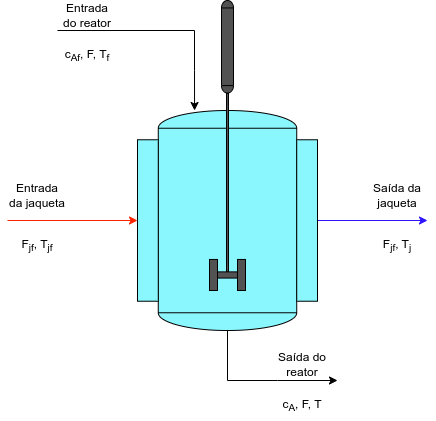


O modelo e dados foram adaptados de [Siddiqui, Anwar e Laskar (2021)](https://www.scopus.com/record/display.uri?eid=2-s2.0-85119937183&origin=resultslist&sort=plf-f&src=s&sid=1164413f5c89e557b590040ff94d9974&sot=b&sdt=b&s=TITLE-ABS-KEY%28%22Control+of+nonlinear+jacketed+continuous+stirred+tank+reactor+using+different+control+structures%22%29&sl=113&sessionSearchId=1164413f5c89e557b590040ff94d9974). Os valores e considerações estão descritos nos códigos e seções subsequentes.

As equações a serem modeladas são as que seguem:

* Taxa reacional:
\begin{align} r_A = k_0 \cdot exp({\frac{-Ea}{RT}}) \cdot c_A \end{align}


* Balanço de massa:
\begin{align} \frac{dc_A}{dt} = \frac{F}{V}(c_{Af} - c_A) - r_A\end{align}


* Balanço de energia do reator:
\begin{align} \frac{dT}{dt} = \frac{F}{V}(T_f - T) + \frac{(-\Delta H)r_A}{\rho c_p} - \frac{UA(T - T_j)}{V \rho c_p}\end{align}


* Balanço de energia na jaqueta:
\begin{align} \frac{dT_j}{dt} = \frac{F_{jf}}{V_j}(T_{jf} - T_j) + \frac{UA(T - T_j)}{V_j \rho_j c_{pj}} \end{align}

# **IMPLEMENTAÇÃO COMPUTACIONAL**

## Prática 1: *Implementação do modelo*

In [ ]:
#bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

#definição
def reator_CSTR(t, x, u, params={}):

  #variáveis de estado
  cA, T, Tj = x

  #variáveis de entrada
  Tjf, Fjf = u      # alimentar Tjf, Fjf = u[0] e u[1]

  #parâmetros dados no artigo - Siddiqui, Anwar e Laskar (2021)
  #reator
  Ea = 32400         #energia de ativação, Btu/lbmol
  dH = -39000        #entalpia da reação, Btu/lbmol
  k0 = 16.96e12      #velocidade específica da reação, h-1
  F = 340            #vazão volumétrica, ft3/h
  V = 85             #volume do reator, ft3
  UA = 6600          #coeficiente de troca térmica, Btu/(h °F)
  R = 1.987          #constante dos gases, Btu/(lbmol R)
  rho_cp = 53.25     #rho*cp, Btu/(ft^2 °F)
  Tf = 60            #temperatura de alimentação, °F
  cAf = 0.132        #concentração na alimentação

  #jaqueta
  Vj = 0.25*V        #volume da jaqueta, ft3
  rhoj_cpj = 55.6    #rhoj*cpj, Btu/(ft^2 °F)

  #relações constitutivas
  rA = k0*np.exp(-Ea/(R*(T+460)))*cA #aqui, é necessário converter a temperatura para Rankine

  #balanço de massa
  dcA = (F/V)*(cAf - cA) - rA

  #balanço de energia - reator
  dT = (F/V)*(Tf - T) - dH*rA/(rho_cp) - UA*(T - Tj)/(V*rho_cp)

  #balanço de energia - jaqueta
  dTj = (Fjf/Vj)*(Tjf - Tj) + UA*(T - Tj)/(Vj*rhoj_cpj)

  dx = [dcA, dT, dTj]

  return dx

#definindo modelo de medição
def medida(t, x, u, params={}):

  #função de medida
  cA, T, Tj = x

  #modelo
  y = [x[1], x[2]]

  return y

### Simulação

Nessa etapa, foi realizada a simulação do modelo com os dados das condições estacionárias para os estados informadas pelo artigo, sendo elas:


*   $c_A = 0.066 \space \text{lbmol/ft}^3$
*   $T_s = 101.1 \space \text{°F}$

Para as entradas, foram informadas duas condições estacionárias para a vazão de fluido refrigerante:

*   $F_{jfs} = 800 \space \text{ft}^3/\text{h}$
*   $F_{jfs} = 270.105 \space \text{ft}^3/\text{h}$

O artigo omite informações quanto à $T_{js}$ e $T_{jfs}$. Para a simulação, assumiu-se que essas temperaturas são de 90 °F e 85 °F, respectivamente, e utilizou-se a vazão de $800 \space \text{ft}^3/\text{h}$.



In [ ]:
# intervalo de integração
tspan = [0, 5]            #tempos inicial e final, em h

#condição inicial/nominal
#variáveis de estado
x0 = [0.066, 101.1, 90]      #cA0, T0, Tj0

#variáveis de entrada
u0 = [85, 800]              #Tjf0, Fjf0

#degrau nas entradas
u0[0] = u0[0] + 0
u0[1] = u0[1] + 0

#instanciando o modelo
modelo = lambda t,x: reator_CSTR(t, x, u0)

#obtendo saídas
sol = solve_ivp(modelo, tspan, x0)

t = sol.t
x = sol.y                 #cA, T, Tj


### Saídas gráficas

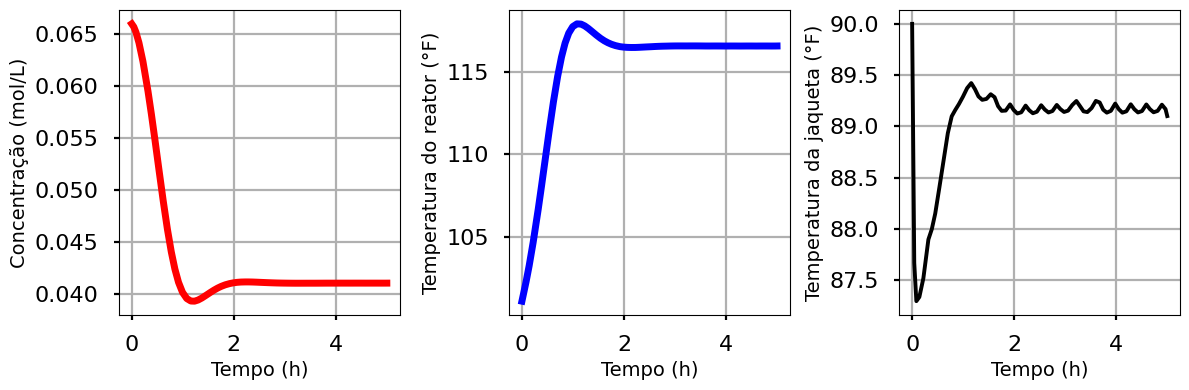

In [ ]:
#configurações
plt.close('all')
plt.rcParams['axes.grid'] = True
plt.style.use('seaborn-v0_8-poster')

#instanciando a figura
h = plt.figure(1, figsize=[12, 4])

#plotagem
plt.subplot(1,3,1)
plt.plot(t, x[0,:], '-r', lw=5)
plt.ylabel('Concentração (mol/L)', fontsize=14)
plt.xlabel('Tempo (h)', fontsize=14)

plt.subplot(1,3,2)
plt.plot(t, x[1,:],'b-', lw=5)
plt.ylabel('Temperatura do reator (°F)', fontsize=14)
plt.xlabel('Tempo (h)', fontsize=14)

plt.subplot(1,3,3)
plt.plot(t, x[2,:], 'k-')
plt.ylabel('Temperatura da jaqueta (°F)', fontsize=14)
plt.xlabel('Tempo (h)', fontsize=14)

# Ajustar o preenchimento entre os subplots
plt.tight_layout()

Efetuando testes degrau com $|\Delta u|=5$ nas entradas, percebe-se que variações na temperatura $T_{jf0}$ provocam grandes alterações no perfil do terceiro gráfico.

## Prática 2: *Linearização e Espaço de Estados*

Para obter o espaço de estados deste processo, foi necessário primeramente obter as condições estacionárias dos estados, tendo em vista que o artigo omitiu algumas informações.

O artigo publicado por [Bequette (2002)](https://ieeexplore.ieee.org/document/1025296), entitulado "Behavior of a CSTR with a Recirculating Jacket Heat Transfer System", que é a principal referência deste estudo, tem como base um exemplo retirado do livro "Elements of Chemical Reaction Engineering" [(Fogler, 1992)](https://www.academia.edu/43095272/Elements_of_Chemical_Reaction_Engineering) e dados do artigo "“Experimental Study of a Bistable Continuous Stirred-Tank Reactor" [(Furusawa; Miyauchi, 1996)](https://www.jstage.jst.go.jp/article/jcej1968/2/1/2_1_95/_pdf).

No exemplo de Fogler (1992), é informado que "a vazão de fluido refrigerante é grande o suficiente para manter a jaqueta a 85 °F" (p.449). Então, admitiu-se os valores estacionários de $85 \space °\text F$ e $800 \space \text{ft}^3/\text{h}$ para as entradas. Depois, aplicou-se a função *fsolve* para obter os valores estacionários dos estados.

In [ ]:
#instalação dos pacotes necessários
! pip install -qq control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.1/455.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
from scipy.optimize import fsolve

# condição estacionária das entradas
us = [85, 800]
t = [0, 3.5]
xs = fsolve(lambda x: reator_CSTR(t, x, us), (0.1, 70, 80))

# condição estacionária dos estados
xs

array([4.10774497e-02, 1.16569725e+02, 8.90790952e+01])

Conforme o código:

*   $c_{As} = 4.10775 \cdot 10^{-2} \space \text{lbmol/ft}^3$
*   $T_s = 116.56973 \space °\text F$
*   $T_{js} = 89.079095 \space °\text F$

In [ ]:
#bibliotecas adicionais necessárias
from scipy import linalg
import control as ct
from control.iosys import linearize

#instanciando o modelo
reator = ct.NonlinearIOSystem(
    updfcn = reator_CSTR,
    outfcn = medida,
    states = ('cA', 'T', 'Tj'),
    inputs = ('Tjf', 'Fjf'),
    outputs = ('T', 'Tj')
)

#linearização
r = ct.linearize(reator, xeq = xs, ueq = us)

#matrizes
A = r.A
B = r.B
C = r.C
D = r.D
sys = ct.ss(A, B, C, D)
sys

<LinearIOSystem:sys[4]:['u[0]', 'u[1]']->['y[0]', 'y[1]']>

A matriz A obtida é diferente daquela proposta pelo artigo, tendo em vista que os pontos estacionários obtidos são diferentes.

## Prática 3: *Função de transferência*

Aqui, a matriz de funções de transferência é dada por:

\begin{align} \textbf{G} = \begin{bmatrix} \frac{T (s)}{T_{jf}(s)} && \frac{T (s)}{F_{jf}(s)} \\ \frac{T_j (s)}{T_{jf}(s)} && \frac{T_j (s)}{F_{jf}(s)} \end{bmatrix} \end{align}

Vamos admitir que queremos controlar a temperatura do reator por meio do controle da temperatura da jaqueta, isto é:

\begin{align} G_p(s) = \frac{T(s)}{T_{jf}(s)} \end{align}

Como função para a perturbação, vamos admitir a função:

\begin{align} G_d(s) = \frac{T(s)}{F_{jf}(s)} \end{align}


In [ ]:
from sympy import symbols, Poly, eye

def ABCD_to_tf(A, B, C, D):
  s = symbols('s')
  n = A.shape[0]
  G = C*(s*eye(n) - A).inv()*B + D
  return G.as_immutable()

def get_tf(g_exp):
  num, den = g_exp.as_numer_denom()
  num_float = [float(i) for i in Poly(num).all_coeffs()]
  den_float = [float(i) for i in Poly(den).all_coeffs()]
  den_ = den_float[-1]
  return ct.tf(np.array(num_float)/den_,
                 np.array(den_float)/den_)

In [ ]:
#obtendo as funções de transferência do sistema
G = ABCD_to_tf(A, B, C, D)
G.simplify()
G[0]

37.6470586233988*(8.14545984805238*s + 104.699849588613)/(5.58611932888198*s**3 + 270.813875896842*s**2 + 1321.55727373543*s + 3737.27764962651)

In [ ]:
G[1]

-0.191957411259069*(8.14545984805238*s + 104.699849588613)/(5.58611932888198*s**3 + 270.813875896842*s**2 + 1321.55727373543*s + 3737.27764962651)

In [ ]:
G[2]

37.6470586233988*(1.0*s**2 + 5.24660904527297*s + 17.8966527569465)/(1.0*s**3 + 48.4797871210252*s**2 + 236.578776057033*s + 669.029326012357)

In [ ]:
G[3]

-0.191957411259069*(1.0*s**2 + 5.24660904527297*s + 17.8966527569465)/(1.0*s**3 + 48.4797871210252*s**2 + 236.578776057033*s + 669.029326012357)

Abaixo, vamos definir o objetivo de controle e a função perturbação.

In [ ]:
# Objetivo de controle:
Gp = G[0]
# Perturbação
Gd = G[1]

## Prática 4: *Análise da dinâmica do processo*

Nessa seção, iremos utilizar funções disponibilizadas pela biblioteca *control* a fim de obter mais informações sobre a dinâmica do processo, como a presença de resposta inversa, polos positivos, ganhos, dentre outras informações relevantes.

In [ ]:
# ganhos
K = sys.dcgain()
K

array([[ 1.05468251, -0.00537769],
       [ 1.00706547, -0.00513489]])

In [ ]:
# polos
sys.pole()

array([ -2.54895511+2.98742196j,  -2.54895511-2.98742196j,
       -43.38187689+0.j        ])

In [ ]:
# Zeros
ny = 2
nu = 2
nx = sys.nstates

z = []
for i in range(ny):
    for j in range(nu):
      g = get_tf(G[i,j])
      z.append(g.zero())

N = len(z)
zeros_positivos = []
for i in range(N):
  if any(z[i]>0):
    zeros_positivos.append(z[i])

M = len(zeros_positivos)
if M>0:
  print('O sistema pode ter resposta inversa.')
  print('Checar os zeros positivos:')
  for i in range(M):
    print(zeros_positivos[i])
else:
  print('O sistema não apresenta zeros positivos. Portanto, não há resposta inversa.')

O sistema não apresenta zeros positivos. Portanto, não há resposta inversa.


In [ ]:
# análise da estabilidade do sistema
p, v = linalg.eig(A)

print('Autovalores da matriz A\nl1 = ', p, '\nl2 = ', v)

if any(np.real(p)>0):
    print('\n O sistema é INSTÁVEL.')
else:
    print('\n O sistema é ESTÁVEL.')

Autovalores da matriz A
l1 =  [ -2.54895511+2.98742196j  -2.54895511-2.98742196j
 -43.38187689+0.j        ] 
l2 =  [[-1.58216893e-03+0.00045868j -1.58216893e-03-0.00045868j
  -1.55495788e-05+0.j        ]
 [ 9.90752799e-01+0.j          9.90752799e-01-0.j
  -2.66099154e-02+0.j        ]
 [ 1.35305083e-01-0.00993538j  1.35305083e-01+0.00993538j
   9.99645893e-01+0.j        ]]

 O sistema é ESTÁVEL.


In [ ]:
# checar controlabilidade e observabilidade do processo.
OB = ct.obsv(A,C)
CO = ct.ctrb(A,B)
if np.linalg.matrix_rank(OB) == sys.nstates:
    print('\n O sistema é observável.')

if np.linalg.matrix_rank(CO) == sys.nstates:
    print('\n O sistema é controlável.')


 O sistema é observável.

 O sistema é controlável.


## Prática 6: *Análise de estabilidade em malha fechada*

O artigo não detalhou funções de transferência específicas para a medição e válvula, então admitiremos as seguintes expressões para $G_v(s)$ e $G_m(s)$:

\begin{align} G_v(s) = 1 \end{align}

\begin{align} G_m(s) = \frac{1}{2s +1} \end{align}

Já as funções de transferência referentes ao processo e perturbação são (aproximadamente):

\begin{align} G_p(s) = \frac{37.64705(8.14546s +104.69985)}{5.58612s^3 + 270.81388s^2+1321.55727s + 3737.27765} \end{align}


\begin{align} G_d(s) = \frac{-0.19195(8.14546s +104.69985)}{5.58612s^3 + 270.81388s^2+1321.55727s + 3737.27765} \end{align}

In [ ]:
# Tamanho padrão das figuras
plt.rcParams["figure.figsize"] = (10,7)

In [ ]:
s = ct.tf('s')
Gp = 37.64705*(8.14546*s +104.69985)/(5.58612*s**3 + 270.81388*s**2+1321.55727*s + 3737.27765)   # função do processo
Gm = 1/(2*s+1)                                                                                  # função da medida
Gd = -0.19195*(8.14546*s +104.69985)/(5.58612*s**3 + 270.81388*s**2+1321.55727*s + 3737.27765)  # função perturbação

Aqui, utilizando a função *control.margin*, vamos obter os valores do limite de estabilidade do processo em malha aberta. Aqui, admitimos $K_c = 1$ pois, posteriormente (na Prática 7), isso permitirá uma escolha direta dos parâmetros dos controladores.

In [ ]:
Kc = 1
Gol = Kc*Gp*Gm
(MG, MF, wc, wg) = ct.margin(Gol)
Pu = 2*np.pi/wc
print(f'wc: {wc:1.4f} rad/min  RA: {1/MG:1.4f}  MG: {MG:1.4f}  Pu: {Pu:1.4f}')

wc: 4.9860 rad/min  RA: 0.0638  MG: 15.6786  Pu: 1.2602


Graficamente, por meio da função *sisotool*:

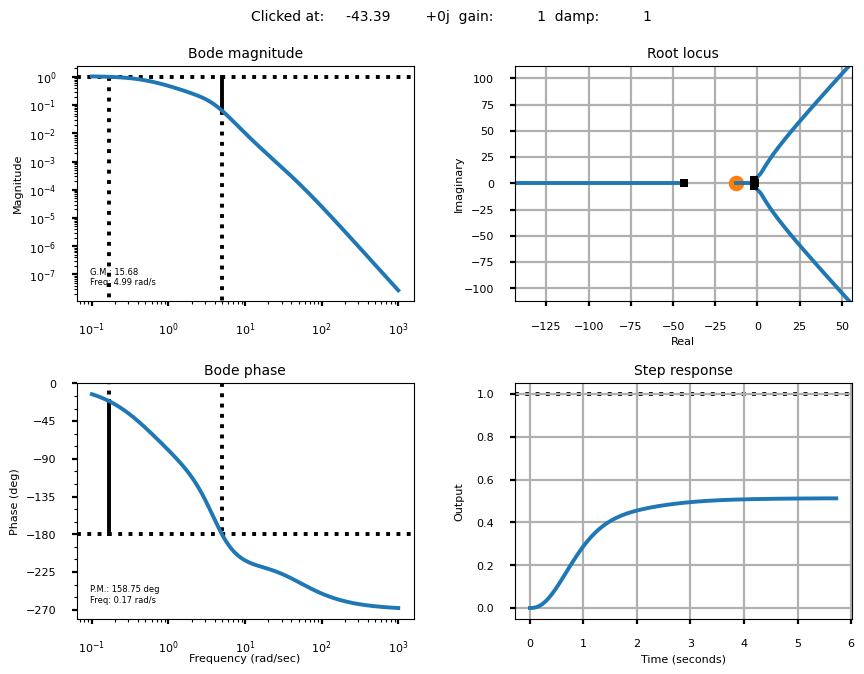

In [ ]:
ct.sisotool(Gol)

Os gráfico superior à esquerda permite a obtenção das frequências $\omega_c$ e $\omega_g$; o inferior permite a leitura da margem de fase para uma determinada frequência (em rad/s). O gráfico superior à direita mostra a localização das raízes da expressão $1 + \text{G}_{OL} = 0$ e o último é uma simulação da malha fechada para um teste servo com degrau unitário.

## Prática 7: *Sintonia de controladores*


Aqui, vamos avaliar a estabilidade do processo em malha fechada para controladores sintonizados por algumas técnicas, e como o processo se comporta nos testes servo e regulador.

**Obs.:** por adicionar um controlador ao processo, essa etapa também contempla a Prática 5: *Efeitos do PID*.

In [ ]:
# Tamanho padrão das figuras
plt.rcParams["figure.figsize"] = (10,4)

In [ ]:
# Implementando um controlador geral
def PID_filtro(kc, tauI = 0.0, tauD = 0.0): # por padrão, tauI e tauD são nulos
  alfa = 0.1                                # fixo

  if tauI != 0.0:
    Gc = kc*(1 + 1/(tauI*s) + (tauD*s)/(alfa*tauD*s + 1))
  else:
    Gc = kc
  return Gc

### **(a) Sintonias Ziegler-Nichols e Tyreus-Luyben**

3 states have been removed from the model
3 states have been removed from the model


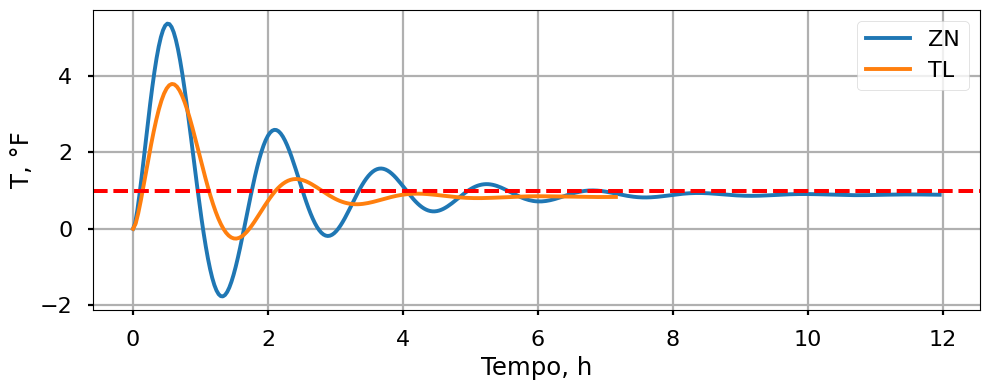

In [ ]:
''' CONTROLADOR PROPORCIONAL '''
# PARÂMETROS DO CONTROLADOR
sintonia_P = [['ZN', MG/2],
              ['TL', MG/3.2]] #------------------------------------ ORDEM: método, parâmetro
# Teste servo
for par in sintonia_P:
  metodo = par[0]
  Kc = par[1]

  ## instanciando o controlador
  Gc = PID_filtro(Kc)

  ## criando a malha fechada
  G_servo = ct.minreal(Gc*Gp/(1+Gc*Gp*Gm)) #---------------------- essa função dá o feedback de polos e zeros que foram cancelados

  ts, ys = ct.step_response(G_servo)

  plt.plot(ts, ys, label = metodo)
  plt.axhline(y = 1, linestyle = '--', color = 'r') #------------ considerando um degrau unitário
  plt.xlabel('Tempo, h')
  plt.ylabel('T, °F')
  plt.legend()

  plt.tight_layout()

3 states have been removed from the model
3 states have been removed from the model


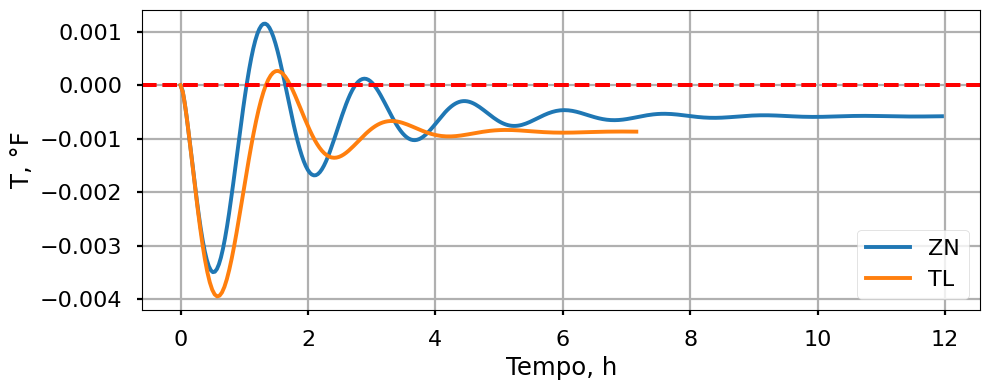

In [ ]:
# Teste regulador
for par in sintonia_P:
  metodo = par[0]
  Kc = par[1]

  ## instanciando o controlador
  Gc = PID_filtro(Kc)

  ## criando a malha fechada
  G_reg = ct.minreal(Gd/(1+Gc*Gp*Gm)) #---------------------- essa função dá o feedback de polos e zeros que foram cancelados

  tr, yr = ct.step_response(G_reg)
  plt.plot(tr, yr, label = metodo)
  plt.axhline(y = 0, linestyle = '--', color = 'r') #--------------- precisa cravar no sp
  plt.xlabel('Tempo, h')
  plt.ylabel('T, °F')
  plt.legend()

  plt.tight_layout()

4 states have been removed from the model
4 states have been removed from the model


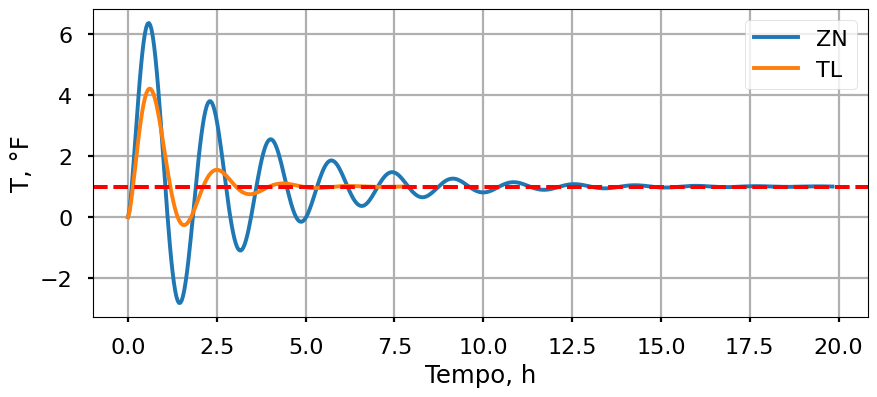

In [ ]:
''' CONTROLADOR PROPORCIONAL-INTEGRAL '''
sintonia_PI = [['ZN', MG/2.2, Pu/1.2],['TL',MG/3.2, Pu/0.45]]

# Teste servo
for par in sintonia_PI:
  metodo = par[0]
  Kc = par[1]
  tauI = par[2]

  ## instanciando o controlador
  Gc = PID_filtro(Kc, tauI)

  G_servo = ct.minreal(Gc*Gp/(1+Gc*Gp*Gm))
  ts, ys = ct.step_response(G_servo)

  # visualizar
  plt.plot(ts, ys, label = metodo)
  plt.axhline(y = 1.0, linestyle = '--', color = 'r')
  plt.xlabel('Tempo, h')
  plt.ylabel('T, °F')
  plt.legend()
  plt.grid()

3 states have been removed from the model
3 states have been removed from the model


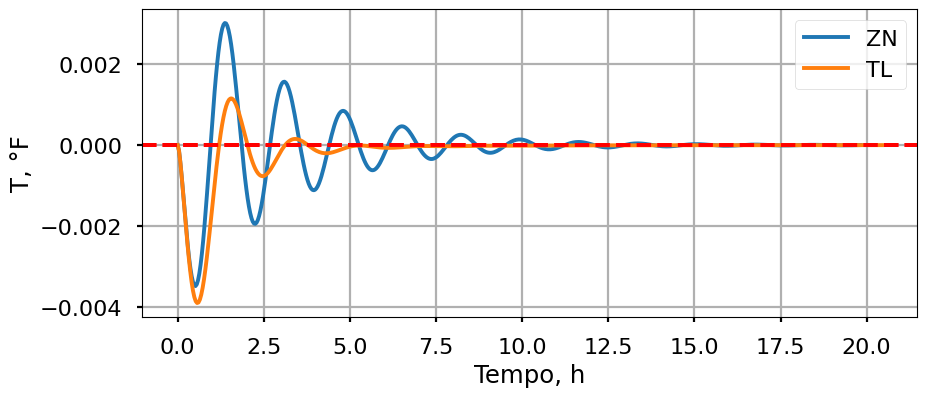

In [ ]:
# Teste regulador
for par in sintonia_PI:
  metodo = par[0]
  Kc = par[1]
  tauI = par[2]

  ## instanciando o controlador
  Gc = PID_filtro(Kc, tauI)

  # TESTE REGULADOR
  G_reg = ct.minreal(Gd/(1+Gc*Gp*Gm))
  tr, yr = ct.step_response(G_reg)

  # visualizar
  plt.plot(tr, yr, label = metodo)
  plt.axhline(y = 0, linestyle = '--', color = 'r')
  plt.xlabel('Tempo, h')
  plt.ylabel('T, °F')
  plt.legend()
  plt.grid()

5 states have been removed from the model
5 states have been removed from the model


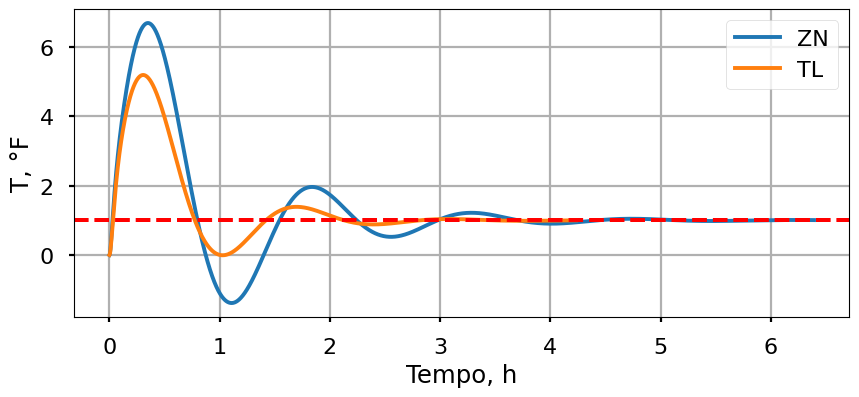

In [ ]:
''' CONTROLADOR PROPORCIONAL-INTEGRAL-DERIVATIVO'''
sintonia_PID = [['ZN', MG/1.7, Pu/2.0, Pu/8.0],['TL', MG/2.20, Pu/0.45, Pu/6.3]]

# TESTE SERVO
for par in sintonia_PID:
  metodo = par[0]
  Kc = par[1]
  tauI = par[2]
  tauD = par[3]

  ## instanciando o controlador
  Gc = PID_filtro(Kc, tauI, tauD)

  ## criando a malha fechada
  G_servo = ct.minreal(Gc*Gp/(1+Gc*Gp*Gm))

  # TESTE SERVO
  ts, ys = ct.step_response(G_servo)

  # visualizar
  plt.plot(ts, ys, label = metodo)
  plt.axhline(y = 1, linestyle = '--', color = 'r')
  plt.xlabel('Tempo, h')
  plt.ylabel('T, °F')
  plt.legend()
  plt.grid()

3 states have been removed from the model
3 states have been removed from the model


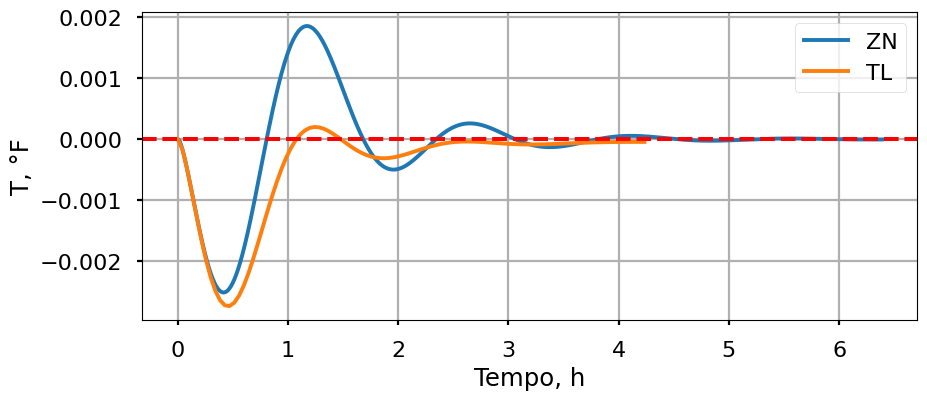

In [ ]:
# Teste regulador
for par in sintonia_PID:
  metodo = par[0]
  Kc = par[1]
  tauI = par[2]
  tauD = par[3]

  ## instanciando o controlador
  Gc = PID_filtro(Kc, tauI, tauD)

  # TESTE REGULADOR
  G_reg = ct.minreal(Gd/(1+Gc*Gp*Gm))
  tr, yr = ct.step_response(G_reg)

  # visualizar
  plt.plot(tr, yr, label = metodo)
  plt.axhline(y = 0, linestyle = '--', color = 'r')
  plt.xlabel('Tempo, h')
  plt.ylabel('T, °F')
  plt.legend()
  plt.grid()

Para as próximas técnicas de sintonia, vamos aplicar a metodologia de Sundaresan e Krishnaswamy para aproximar a função $G(s)$ por uma função do tipo:

\begin{align} G(s) = G_p(s) G_m(s) G_v(s) \approx \tilde{G}(s) = \frac{K e^{-\theta s}}{\tau_{p} s + 1}\end{align}

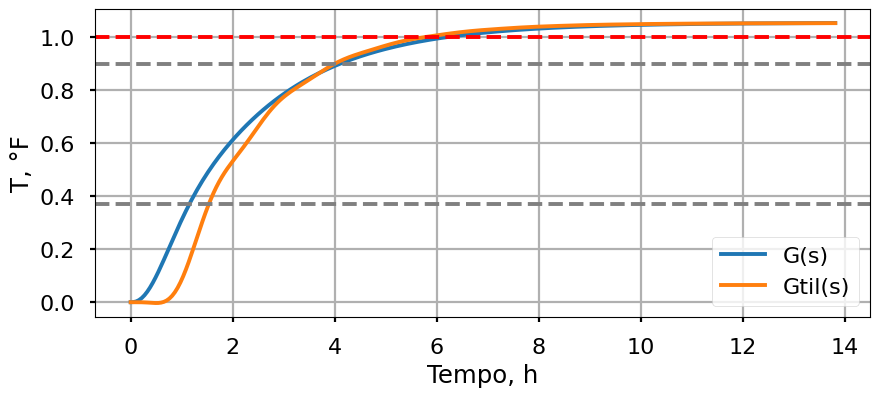

In [ ]:
# aplicando teste degrau no processo
t, y = ct.step_response(Gp*Gm)

# aplicando o método
delta_y = y[-1] - y[0]

# pelo gráfico...
t1 = 1.54 # em min
t2 = 4

# parâmetros do processo aproximado
theta = 1.3*t1 - 0.29*t2
taup = 0.67*(t2 - t1)
Kp = delta_y
Gtil = Kp/(taup*s+1)*ct.tf(*ct.pade(theta,5,1))

# aplicando teste degrau no processo aproximado
t, ytil = ct.step_response(Gtil, t)

# visualizando
plt.plot(t, y, label = f'G(s)')
plt.plot(t, ytil, label = f'Gtil(s)')
plt.axhline(y = 1, linestyle = '--', color = 'r')
plt.axhline(y = y[0] + 0.353*delta_y, linestyle = '--', color = 'gray')
plt.axhline(y = y[0] + 0.853*delta_y, linestyle = '--', color = 'gray')
plt.xlabel('Tempo, h')
plt.ylabel('T, °F')
plt.legend()


In [ ]:
# exibindo os parâmetros do processo aproximado
Kp, taup, theta

(1.0534771487385117, 1.6482, 0.8420000000000003)

### **(b) Método IMC**

In [ ]:
# sintonias - PI e PID conforme tabela 12.1 do Seborg et al. (2011)
tauc = theta
sintonias_IMC = [['IMC - PI', taup/(Kp*tauc + theta), taup, 0],
                ['IMC - PID', taup/(Kp*tauc + theta/2), taup + theta/2, (taup*theta)/(2*taup + theta)]]

#### *Testes servo  e regulador - processo aproximado*

8 states have been removed from the model
8 states have been removed from the model


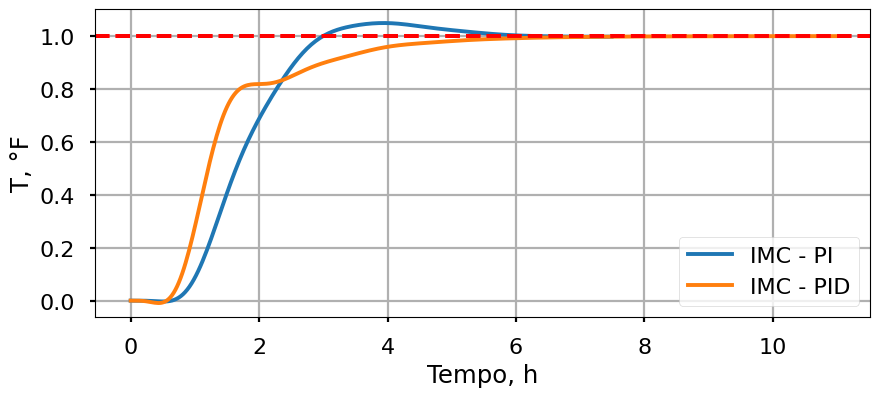

In [ ]:
# TESTE SERVO
for par in sintonias_IMC:
  metodo = par[0]
  Kc = par[1]
  tauI = par[2]
  tauD = par[3]

  ## instanciando o controlador
  Gc = PID_filtro(Kc, tauI, tauD)

  ## criando a malha fechada
  G_servo = ct.minreal(Gc*Gtil/(1+Gc*Gtil))

  # TESTE SERVO
  ts, ys = ct.step_response(G_servo)

  # visualizar
  plt.plot(ts, ys, label = metodo)
  plt.axhline(y = 1, linestyle = '--', color = 'r')
  plt.xlabel('Tempo, h')
  plt.ylabel('T, °F')
  plt.legend()
  plt.grid()

1 states have been removed from the model
0 states have been removed from the model


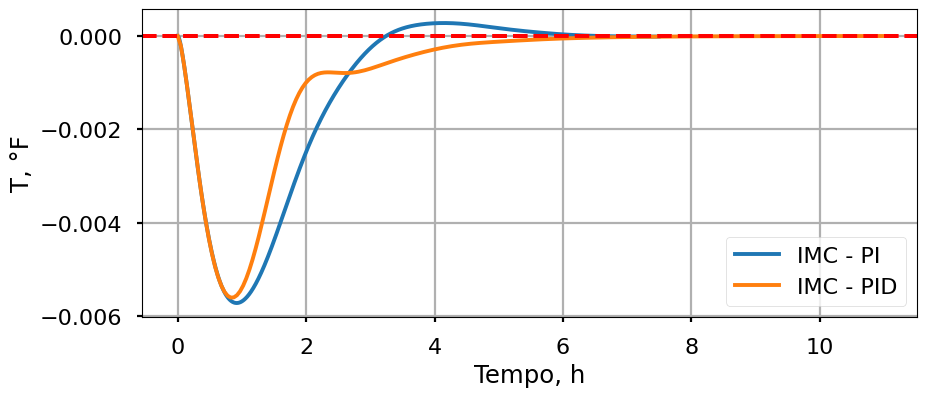

In [ ]:
# Teste regulador
for par in sintonias_IMC:
  metodo = par[0]
  Kc = par[1]
  tauI = par[2]
  tauD = par[3]

  ## instanciando o controlador
  Gc = PID_filtro(Kc, tauI, tauD)

  # TESTE REGULADOR
  G_reg = ct.minreal(Gd/(1+Gc*Gtil))
  tr, yr = ct.step_response(G_reg)

  # visualizar
  plt.plot(tr, yr, label = metodo)
  plt.axhline(y = 0, linestyle = '--', color = 'r')
  plt.xlabel('Tempo, h')
  plt.ylabel('T, °F')
  plt.legend()
  plt.grid()

#### *Testes servo e regulador - processo real*

5 states have been removed from the model
6 states have been removed from the model


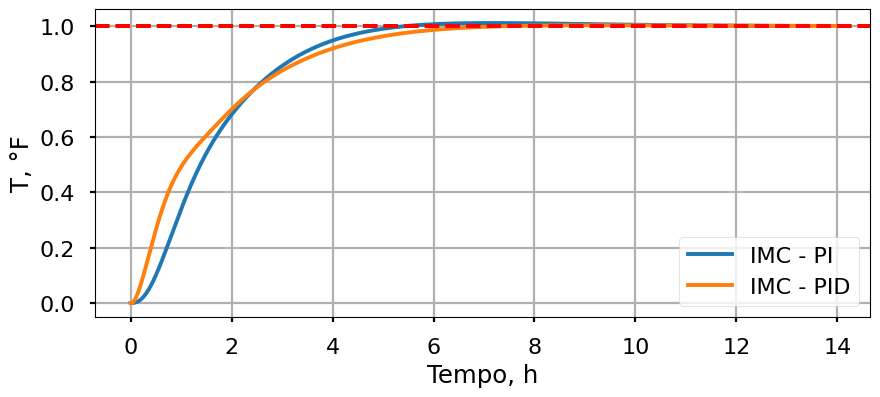

In [ ]:
# TESTE SERVO
for par in sintonias_IMC:
  metodo = par[0]
  Kc = par[1]
  tauI = par[2]
  tauD = par[3]

  ## instanciando o controlador
  Gc = PID_filtro(Kc, tauI, tauD)

  ## criando a malha fechada
  G_servo = ct.minreal(Gc*Gp*Gm/(1+Gc*Gp*Gm))

  # TESTE SERVO
  ts, ys = ct.step_response(G_servo)

  # visualizar
  plt.plot(ts, ys, label = metodo)
  plt.axhline(y = 1, linestyle = '--', color = 'r')
  plt.xlabel('Tempo, h')
  plt.ylabel('T, °F')
  plt.legend()
  plt.grid()

3 states have been removed from the model
3 states have been removed from the model


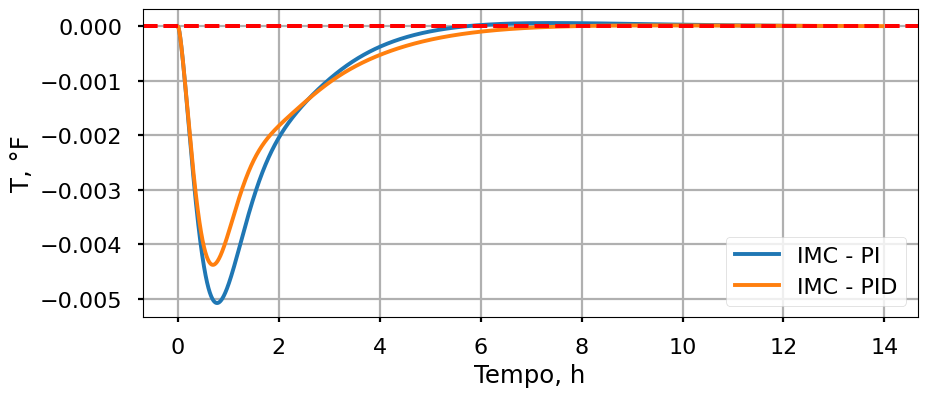

In [ ]:
# Teste regulador
for par in sintonias_IMC:
  metodo = par[0]
  Kc = par[1]
  tauI = par[2]
  tauD = par[3]

  ## instanciando o controlador
  Gc = PID_filtro(Kc, tauI, tauD)

  # TESTE REGULADOR
  G_reg = ct.minreal(Gd/(1+Gc*Gp*Gm))
  tr, yr = ct.step_response(G_reg)

  # visualizar
  plt.plot(tr, yr, label = metodo)
  plt.axhline(y = 0, linestyle = '--', color = 'r')
  plt.xlabel('Tempo, h')
  plt.ylabel('T, °F')
  plt.legend()
  plt.grid()

### **(c) Critério integral - ITAE**

In [ ]:
# sintonias
# teste regulador
sintonias_ITAE = [['PI$_{reg}$', 0.859/Kp*(theta/taup)**(-0.977), taup/(0.674*(theta/taup)**(-0.680)), 0],
                ['PID$_{reg}$', 1.357/Kp*(theta/taup)**(-0.947), taup/(0.842*(theta/taup)**(-0.738)), taup*0.381*(theta/taup)**0.995],
                ['PI$_{servo}$', 0.586/Kp*(theta/taup)**(-0.916), taup/(1.03*(theta/taup)**(-0.165)), 0],
                ['PID$_{servo}$', 0.965/Kp*(theta/taup)**(-0.850), taup/(0.796*(theta/taup)**(-0.147)), taup*0.308*(theta/taup)**0.929]]

#### *Testes servo e regulador - processo aproximado*


7 states have been removed from the model
8 states have been removed from the model
7 states have been removed from the model
8 states have been removed from the model


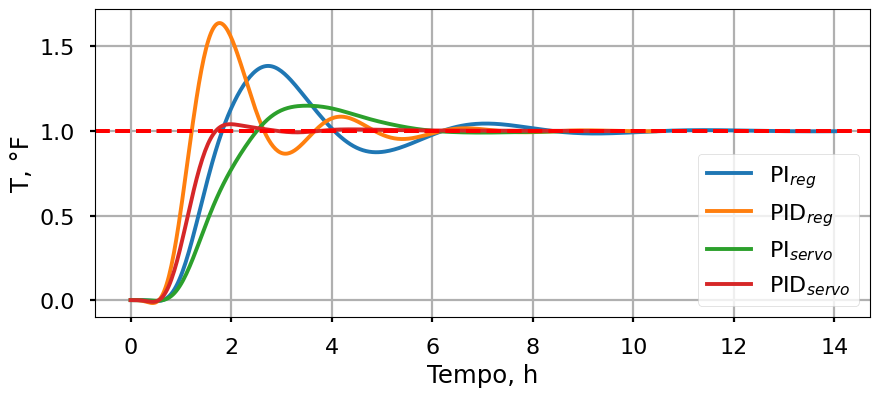

In [ ]:
# TESTE SERVO
for par in sintonias_ITAE:
  metodo, Kc, tauI, tauD = par

  ## instanciando o controlador
  Gc = PID_filtro(Kc, tauI, tauD)

  ## criando a malha fechada
  G_servo = ct.minreal(Gc*Gtil/(1+Gc*Gtil))

  # TESTE SERVO
  ts, ys = ct.step_response(G_servo)

  # visualizar
  plt.plot(ts, ys, label = metodo)
  plt.axhline(y = 1, linestyle = '--', color = 'r')
  plt.xlabel('Tempo, h')
  plt.ylabel('T, °F')
  plt.legend()
  plt.grid()

0 states have been removed from the model
0 states have been removed from the model
0 states have been removed from the model
0 states have been removed from the model


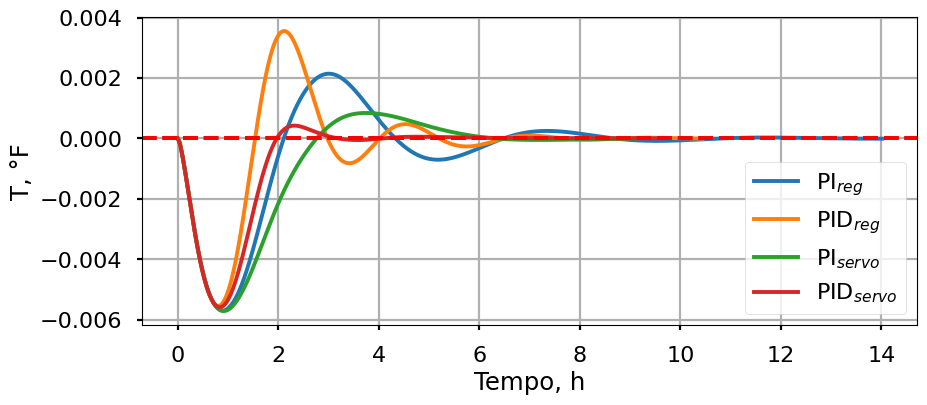

In [ ]:
# Teste regulador
for par in sintonias_ITAE:
  metodo, Kc, tauI, tauD = par

  ## instanciando o controlador
  Gc = PID_filtro(Kc, tauI, tauD)

  # TESTE REGULADOR
  G_reg = ct.minreal(Gd/(1+Gc*Gtil))
  tr, yr = ct.step_response(G_reg)

  # visualizar
  plt.plot(tr, yr, label = metodo)
  plt.axhline(y = 0, linestyle = '--', color = 'r')
  plt.xlabel('Tempo, h')
  plt.ylabel('T, °F')
  plt.legend()
  plt.grid()

#### *Testes servo e regulador - processo real*

5 states have been removed from the model
6 states have been removed from the model
5 states have been removed from the model
6 states have been removed from the model


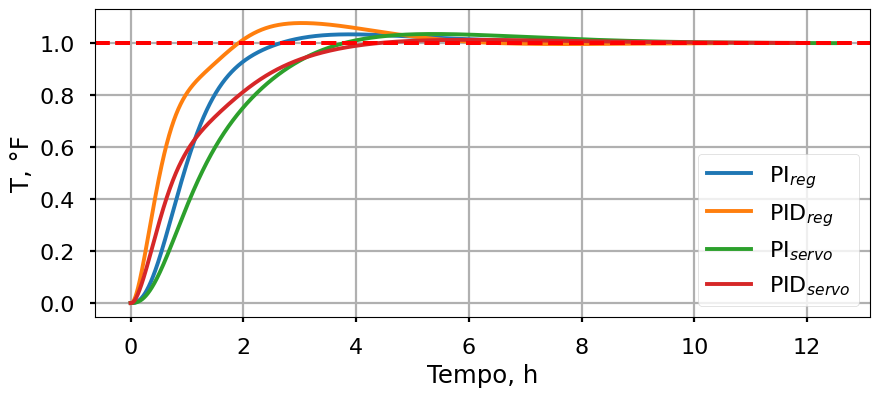

In [ ]:
# TESTE SERVO
for par in sintonias_ITAE:
  metodo, Kc, tauI, tauD = par

  ## instanciando o controlador
  Gc = PID_filtro(Kc, tauI, tauD)

  ## criando a malha fechada
  G_servo = ct.minreal(Gc*Gp*Gm/(1+Gc*Gp*Gm))

  # TESTE SERVO
  ts, ys = ct.step_response(G_servo)

  # visualizar
  plt.plot(ts, ys, label = metodo)
  plt.axhline(y = 1, linestyle = '--', color = 'r')
  plt.xlabel('Tempo, h')
  plt.ylabel('T, °F')
  plt.legend()
  plt.grid()

3 states have been removed from the model
3 states have been removed from the model
3 states have been removed from the model
3 states have been removed from the model


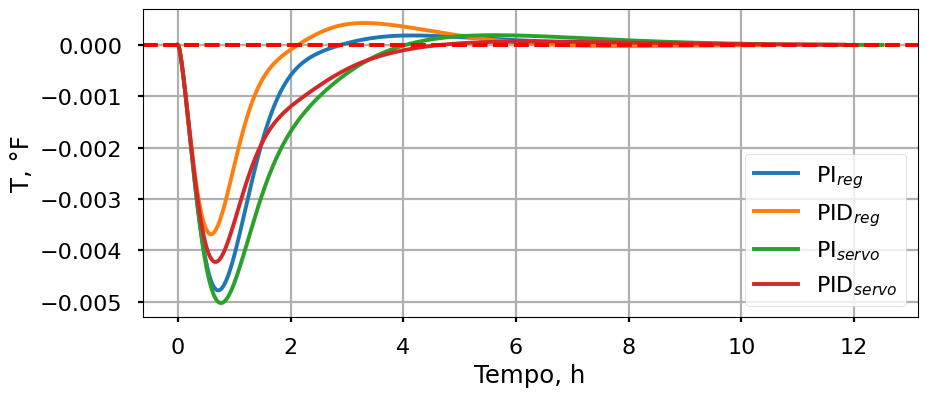

In [ ]:
# Teste regulador
for par in sintonias_ITAE:
  metodo, Kc, tauI, tauD = par

  ## instanciando o controlador
  Gc = PID_filtro(Kc, tauI, tauD)

  # TESTE REGULADOR
  G_reg = ct.minreal(Gd/(1+Gc*Gp*Gm))
  tr, yr = ct.step_response(G_reg)

  # visualizar
  plt.plot(tr, yr, label = metodo)
  plt.axhline(y = 0, linestyle = '--', color = 'r')
  plt.xlabel('Tempo, h')
  plt.ylabel('T, °F')
  plt.legend()
  plt.grid()

## Panorama geral do desempenho dos controladores

O processo avaliado apresenta uma dinâmica bastante complexa. Mesmo assim, as metodologias aplicadas foram capazes de fornecer controladores capazes de estabilizar o processo. Algumas observações podem ser feitas acerca das metodologias avaliadas:


*    As sintonias de Ziegler-Nichols (ZN) e Tyreus-Luyben (TL) forneceram os controladores cuja resposta apresentou mais oscilação em ambos os testes, sendo a sintonia TL menos oscilatória. Em ambas as sintonias, o controlador mais eficiente, em termos de alcançar o estado final mais rapidamente, foi o PID.

*    Apesar de admitirem uma aproximação do processo, as sintonias IMC e os critérios integrais apresentaram bom desempenho ao serem submetidas ao processo real.

*    As sintonias via critérios integrais e IMC foram as menos oscilatórias. Inclusive, ao serem aplicadas no processo real, as oscilações foram grandemente reduzidas em ambos os testes. Ademais, o tempo de assentamento foi reduzido após aplicação dos controladores no processo real.

# **CONCLUSÃO**

É de fundamental importância que o engenheiro químico conheça os fenômenos físico-químicos de uma planta industrial. Com o avanço e o advento da utilização de novas tecnologias, tornou-se possível desenvolver estratégias de controle e monitoramento mais eficazes.

Este trabalho contemplou a escolha de um processo comum à Engenharia Química, sua simulação, análise e implementação das sintonias de controladores PID mais aplicadas. Neste processo, foram verificadas dificuldades comuns à área acadêmica e industrial, como a omissão de informações importantes para o desenvolvimento integral de uma solução. No entanto, a utilização das ferramentas disponíveis permitiu o prosseguimento do trabalho com resultados satisfatórios.

Em suma, este estudo reforça a importância contínua da pesquisa e da aplicação de conhecimentos avançados na Engenharia Química, contribuindo para o aprimoramento das operações industriais e o avanço da área.


